In [1]:
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandahouse as ph
import scipy as sp
import seaborn as sns

# Соединение с ClickHouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database': 'simulator_20221220',
    'user': 'student',
    'password': 'dpo_python_2020'
}

# Запрос
query = """
SELECT
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) BETWEEN '2022-12-02' AND '2022-12-08'
    AND exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

# Загрузить данные
df = ph.read_clickhouse(query, connection=connection)
df.sort_values(['exp_group', 'user_id'], inplace=True)
print('ОБЩИЕ ДАННЫЕ:', '\n', df, '\n')


ОБЩИЕ ДАННЫЕ: 
        exp_group  user_id  likes  views       ctr
15545          1      206      6     38  0.157895
14471          1      216      3     27  0.111111
6368           1      243     15     95  0.157895
4433           1      274     16    102  0.156863
5060           1      276     11     32  0.343750
...          ...      ...    ...    ...       ...
19145          2   140476      8     31  0.258065
6760           2   140491      3     13  0.230769
16667          2   140495     17     84  0.202381
7148           2   140499     15     73  0.205479
16688          2   141164      0      1  0.000000

[20031 rows x 5 columns] 



In [2]:
def get_smoothed_ctr(user_likes, user_views, group_ctr, alpha):
    """
    Получить CTR, сглаженный по Лапласу

    :param user_likes: кол-во лайков у пользователя
    :param user_views: кол-во просмотров у пользователя
    :param group_ctr: общий CTR у группы пользователей
    :param alpha: гиперпараметр сглаживания
    :return: сглаженный CTR
    """

    smoothed_ctr = \
        (user_likes + alpha * group_ctr) / \
        (user_views + alpha)

    return smoothed_ctr


# Получить отдельные данные для каждой группы
group1_df = df[df.exp_group == 1].copy()
group2_df = df[df.exp_group == 2].copy()

# Рассчитать ОБЩИЙ CTR для каждой группы
group1_ctr = group1_df.likes.sum() / group1_df.views.sum()
group2_ctr = group2_df.likes.sum() / group2_df.views.sum()

# Рассчитать СГЛАЖЕННЫЙ CTR для каждой группы
group1_df['smoothed_ctr'] = group1_df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], group1_ctr, 5), axis=1)

group2_df['smoothed_ctr'] = group2_df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], group2_ctr, 5), axis=1)

# Проверка полученных данных
print('ГРУППА 1: ', '\n', group1_df, '\n')
print('ГРУППА 2: ', '\n', group2_df, '\n')


ГРУППА 1:  
        exp_group  user_id  likes  views       ctr  smoothed_ctr
15545          1      206      6     38  0.157895      0.163724
14471          1      216      3     27  0.111111      0.126254
6368           1      243     15     95  0.157895      0.160401
4433           1      274     16    102  0.156863      0.159254
5060           1      276     11     32  0.343750      0.325409
...          ...      ...    ...    ...       ...           ...
17507          1   140409      2     14  0.142857      0.160007
17730          1   140446     10     51  0.196078      0.197145
19382          1   140455      2     17  0.117647      0.138188
354            1   140469     10     27  0.370370      0.345004
16903          1   140500      7     21  0.333333      0.309236

[10079 rows x 6 columns] 

ГРУППА 2:  
        exp_group  user_id  likes  views       ctr  smoothed_ctr
14826          2      220     14     33  0.424242      0.394482
6719           2      224      3      9  0.333333 

## Сравнение исходных и сглаженных данных для каждой группы

Стандартные отклонения распределений
Группа №1, CTR:             0.08415534432573063
Группа №1, Сглаженный-CTR:  0.07136453134461666
Группа №2, CTR:             0.14417274020530849
Группа №2, Сглаженный-CTR:  0.12476149994385737


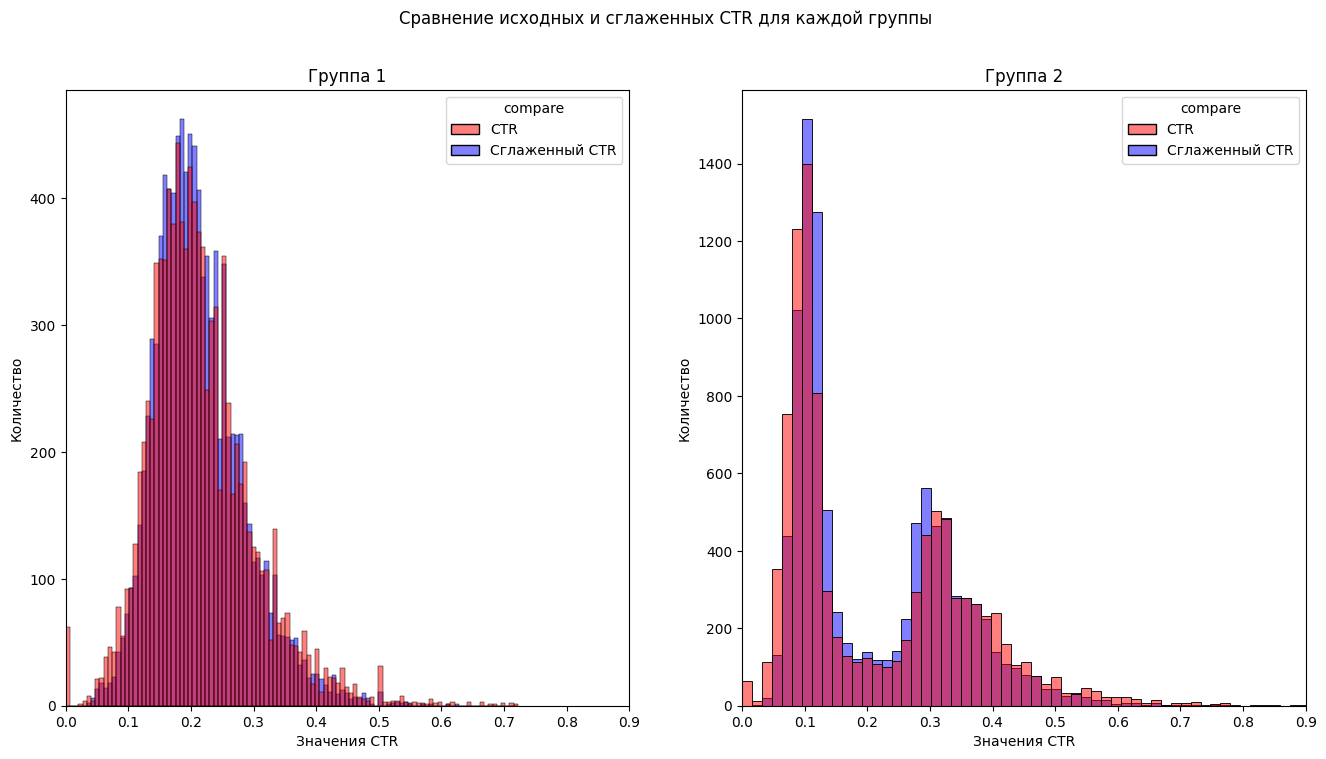

In [3]:
compare1_df = pd.concat([
    group1_df.rename(columns={'ctr': 'values'}).assign(compare='CTR'),
    group1_df.rename(columns={'smoothed_ctr': 'values'}).assign(compare='Сглаженный CTR')
])

compare2_df = pd.concat([
    group2_df.rename(columns={'ctr': 'values'}).assign(compare='CTR'),
    group2_df.rename(columns={'smoothed_ctr': 'values'}).assign(compare='Сглаженный CTR')
])

# print(compare1_df)
# print(compare2_df)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Сравнение исходных и сглаженных CTR для каждой группы')

sns.histplot(
    ax = axes[0],
    bins = 'auto',
    data = compare1_df,
    x = 'values',
    hue = 'compare',
    palette = ['r', 'b'],
    alpha = 0.5,
    kde = False
)

sns.histplot(
    ax = axes[1],
    bins = 'auto',
    data = compare2_df,
    x = 'values',
    hue = 'compare',
    palette = ['r', 'b'],
    alpha = 0.5,
    kde = False
)

axes[0].set_xlim(0, 0.9)
# axes[0].set_ylim(0, 550)
axes[0].set_title('Группа 1')
axes[0].set_xlabel('Значения CTR')
axes[0].set_ylabel('Количество')

axes[1].set_xlim(0, 0.9)
# axes[1].set_ylim(0, 550)
axes[1].set_title('Группа 2')
axes[1].set_xlabel('Значения CTR')
axes[1].set_ylabel('Количество')

print("Стандартные отклонения распределений")
print("Группа №1, CTR:            ", np.std(group1_df.ctr))
print("Группа №1, Сглаженный-CTR: ", np.std(group1_df.smoothed_ctr))
print("Группа №2, CTR:            ", np.std(group2_df.ctr))
print("Группа №2, Сглаженный-CTR: ", np.std(group2_df.smoothed_ctr))


### Выводы
Мы можем наблюдать что распределения CTR для обеих групп (Группа №1 и Группа №2) имеют большее количество наблюдений "на концах" распределений, в то время как распределения Сглаженных-CTR для обеих групп (Группа №1 и Группа №2) имеют большее количество наблюдений ближе к медиане распределений. Это также демонстрируется значениями стандартных отклонений (см. выше): для "сглаженных" распределений стандартные отклонения меньше.


## Сравнение исходных и сглаженных CTR между группами
### Визуализация

Text(0, 0.5, 'Количество')

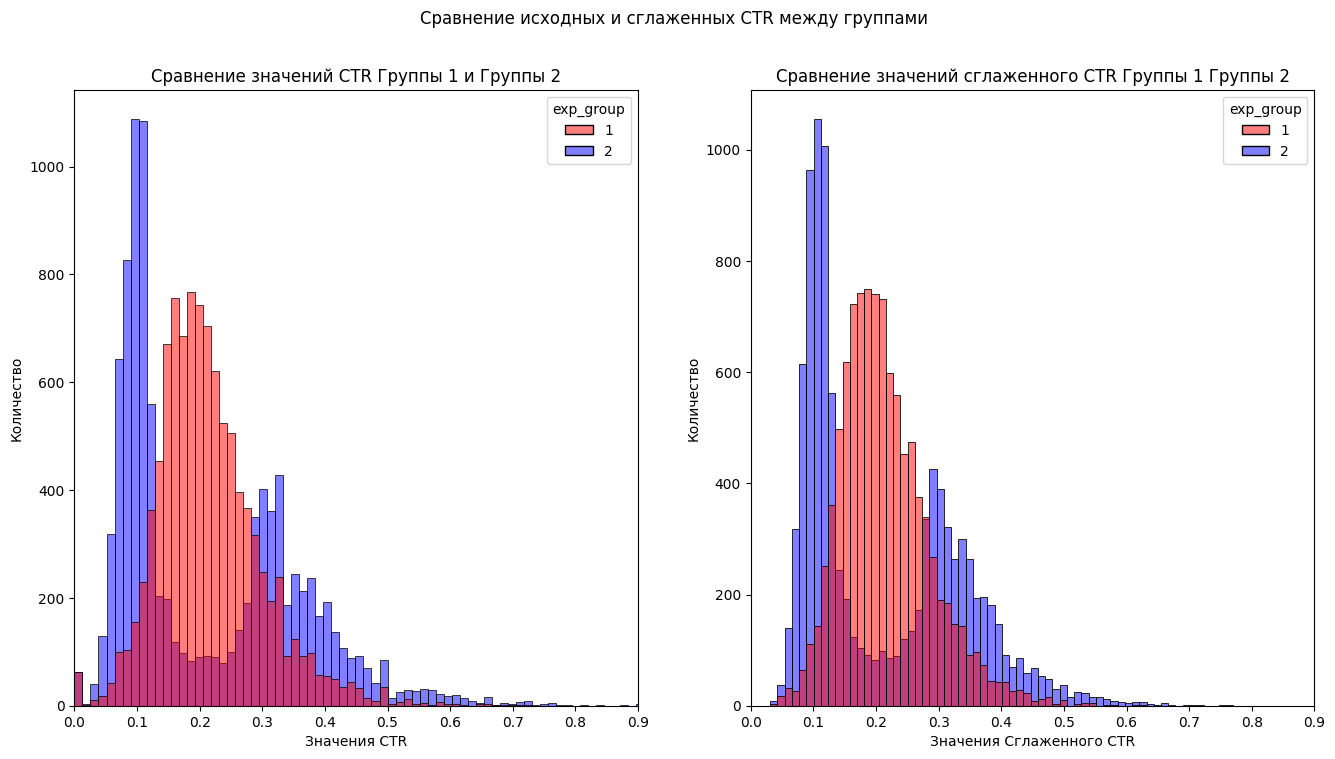

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Сравнение исходных и сглаженных CTR между группами')

sns.histplot(
    ax = axes[0],
    bins = 'auto',
    data = pd.concat([group1_df, group2_df]),
    x = 'ctr',
    hue = 'exp_group',
    palette = ['r', 'b'],
    alpha = 0.5,
    kde = False
)

sns.histplot(
    ax = axes[1],
    bins = 'auto',
    data = pd.concat([group1_df, group2_df]),
    x = 'smoothed_ctr',
    hue = 'exp_group',
    palette = ['r', 'b'],
    alpha = 0.5,
    kde = False
)

axes[0].set_xlim(0, 0.9)
# axes[0].set_ylim(0, 550)
axes[0].set_title('Сравнение значений CTR Группы 1 и Группы 2')
axes[0].set_xlabel('Значения CTR')
axes[0].set_ylabel('Количество')

axes[1].set_xlim(0, 0.9)
# axes[1].set_ylim(0, 550)
axes[1].set_title('Сравнение значений сглаженного CTR Группы 1 Группы 2')
axes[1].set_xlabel('Значения Сглаженного CTR')
axes[1].set_ylabel('Количество')


### Визуализация. Выводы
Мы можем наблюдать что распределения CTR и Сглаженных-CTR значительно различаются между группами.
Распределения Группы №1 являются одномодальными, в то время как распределения Группы №2 являются двухмодальными.
Двумодальность распределения №2 позволяет предположить что аудитория Группы №2 разбилась на две подгруппы.
Первая подгруппа (большего размера) продемонстрировала снижение CTR, в то время как вторая подгруппа (меньшего размера) продемонстрировала повышение CTR.
Из этого можно сделать предварительный вывод что в целом Группа №1 демонстрирует более высокий CTR чем Группа №2.
Тем не менее, эта гипотеза нуждается в аналитическом подтверждении.


## Сравнение исходных и сглаженных CTR между группами
### Анализ

In [5]:
group1_ctr_shapiro = sp.stats.shapiro(group1_df.ctr)
group1_ctr_dagostino = sp.stats.normaltest(group1_df.ctr)
group1_smoothed_ctr_shapiro = sp.stats.shapiro(group1_df.smoothed_ctr)
group1_smoothed_ctr_dagostino = sp.stats.normaltest(group1_df.smoothed_ctr)

group2_ctr_shapiro = sp.stats.shapiro(group2_df.ctr)
group2_ctr_dagostino = sp.stats.normaltest(group2_df.ctr)
group2_smoothed_ctr_shapiro = sp.stats.shapiro(group2_df.smoothed_ctr)
group2_smoothed_ctr_dagostino = sp.stats.normaltest(group2_df.smoothed_ctr)

# Т-критерий Стьюдента для независимых выборок
# Гипотеза: среднее значение распределения Группы №1
# стохастически БОЛЬШЕ среднего значения распределения Группы №2
# То есть у Группы №1 (контрольной) в среднем CTR выше чем у Группы №2
ctr_ttest = sp.stats.ttest_ind(
    group1_df.ctr,
    group2_df.ctr,
    equal_var=False,
    alternative='greater'
)

smoothed_ctr_ttest = sp.stats.ttest_ind(
    group1_df.smoothed_ctr,
    group2_df.smoothed_ctr,
    equal_var=False,
    alternative='greater'
)

# U-критерий Манна-Уитни
# Гипотеза: распределение Группы №1 стохастически БОЛЬШЕ распределения Группы №2
# То есть у Группы №1 (контрольной) CTR выше чем у Группы №2
ctr_mwutest = sp.stats.mannwhitneyu(
    group1_df.ctr,
    group2_df.ctr,
    alternative = 'greater'
)

smoothed_ctr_mwutest = sp.stats.mannwhitneyu(
    group1_df.smoothed_ctr,
    group2_df.smoothed_ctr,
    alternative = 'greater'
)

print("Группа №1, распределение CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group1_ctr_shapiro[1])
print("Критерий Д'Агостино:   ", group1_ctr_dagostino[1])

print("\nГруппа №1, распределение Сглаженного-CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group1_smoothed_ctr_shapiro[1])
print("Критерий Д'Агостино:   ", group1_smoothed_ctr_dagostino[1])

print("\nГруппа №2, распределение CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group2_ctr_shapiro[1])
print("Критерий Д'Агостино:   ", group2_ctr_dagostino[1])

print("\nГруппа №2, распределение cглаженного-CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group2_smoothed_ctr_shapiro[1])
print("Критерий Д'Агостино:   ", group2_smoothed_ctr_dagostino[1])

print("\nГруппы №1-№2, сравнение CTR:")
print('Т-критерий Стьюдента:   ', ctr_ttest[1])
print('U-критерий Манна-Уитни: ', ctr_mwutest[1])

print("\nГруппы №1-№2, сравнение сглаженного-CTR:")
print('Т-критерий Стьюдента:   ', smoothed_ctr_ttest[1])
print('U-критерий Манна-Уитни: ', smoothed_ctr_mwutest[1])


Группа №1, распределение CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    0.0

Группа №1, распределение Сглаженного-CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    4.2670145155456926e-291

Группа №2, распределение CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    3.498793725649664e-195

Группа №2, распределение cглаженного-CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    1.0323496559896614e-173

Группы №1-№2, сравнение CTR:
Т-критерий Стьюдента:    0.23903115654374674
U-критерий Манна-Уитни:  3.0188242308889518e-56

Группы №1-№2, сравнение сглаженного-CTR:
Т-критерий Стьюдента:    0.011188490777927378
U-критерий Манна-Уитни:  8.081982057135114e-62


/home/manjie/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Выводы
Проверка на нормальность продемонстрировала, что ни одно из распределений CTR и сглаженного-CTR для Групп №1 и №2 <b>не является нормальным</b>. Это ставит под сомнение валидность использования Т-критерия для сравнения распределений между группами. Тем не менее, мы приводим результаты Т-критерия для справки.

Основываясь на результатах визуального анализа мы выдвинули предварительную гипотезу о том что Группа №1 демонстрирует более высокие значения CTR и сглаженного CTR.
Для того чтобы проверить эту гипотезу мы использовали Т-критерий Стьюдента и U-критерий Манна-Уитни.
Т-критерий Стьюдента показал отсутствие различия для CTR и превосходство Группы №1 для сглаженного-CTR.
U-критерий Манна-Уитни показал превосходство Группы №1 и для CTR и для сглаженного-CTR.

Учитывая визуальный анализ и то что исследуемые распределения не являются нормальными, что отдает предпочтение U-критерий Манна-Уитни, можно заключить что внедрение нового алгоритма рекомендации постов (продемонстрированного Группой №2) ухудшило общий CTR.
Следовательно, <b>мы не можем рекомендовать алгоритм для внедрения</b>.
Несмотря на проделанный анализ, мы продолжим сравнивать CTR, используя другие методы.

## Пуассоновский бутстреп для подсчета разницы в CTR

<AxesSubplot:title={'center':'Группа №1, Группа №2: Разница между распределениями CTR'}, xlabel='Разница в CTR', ylabel='Количество'>

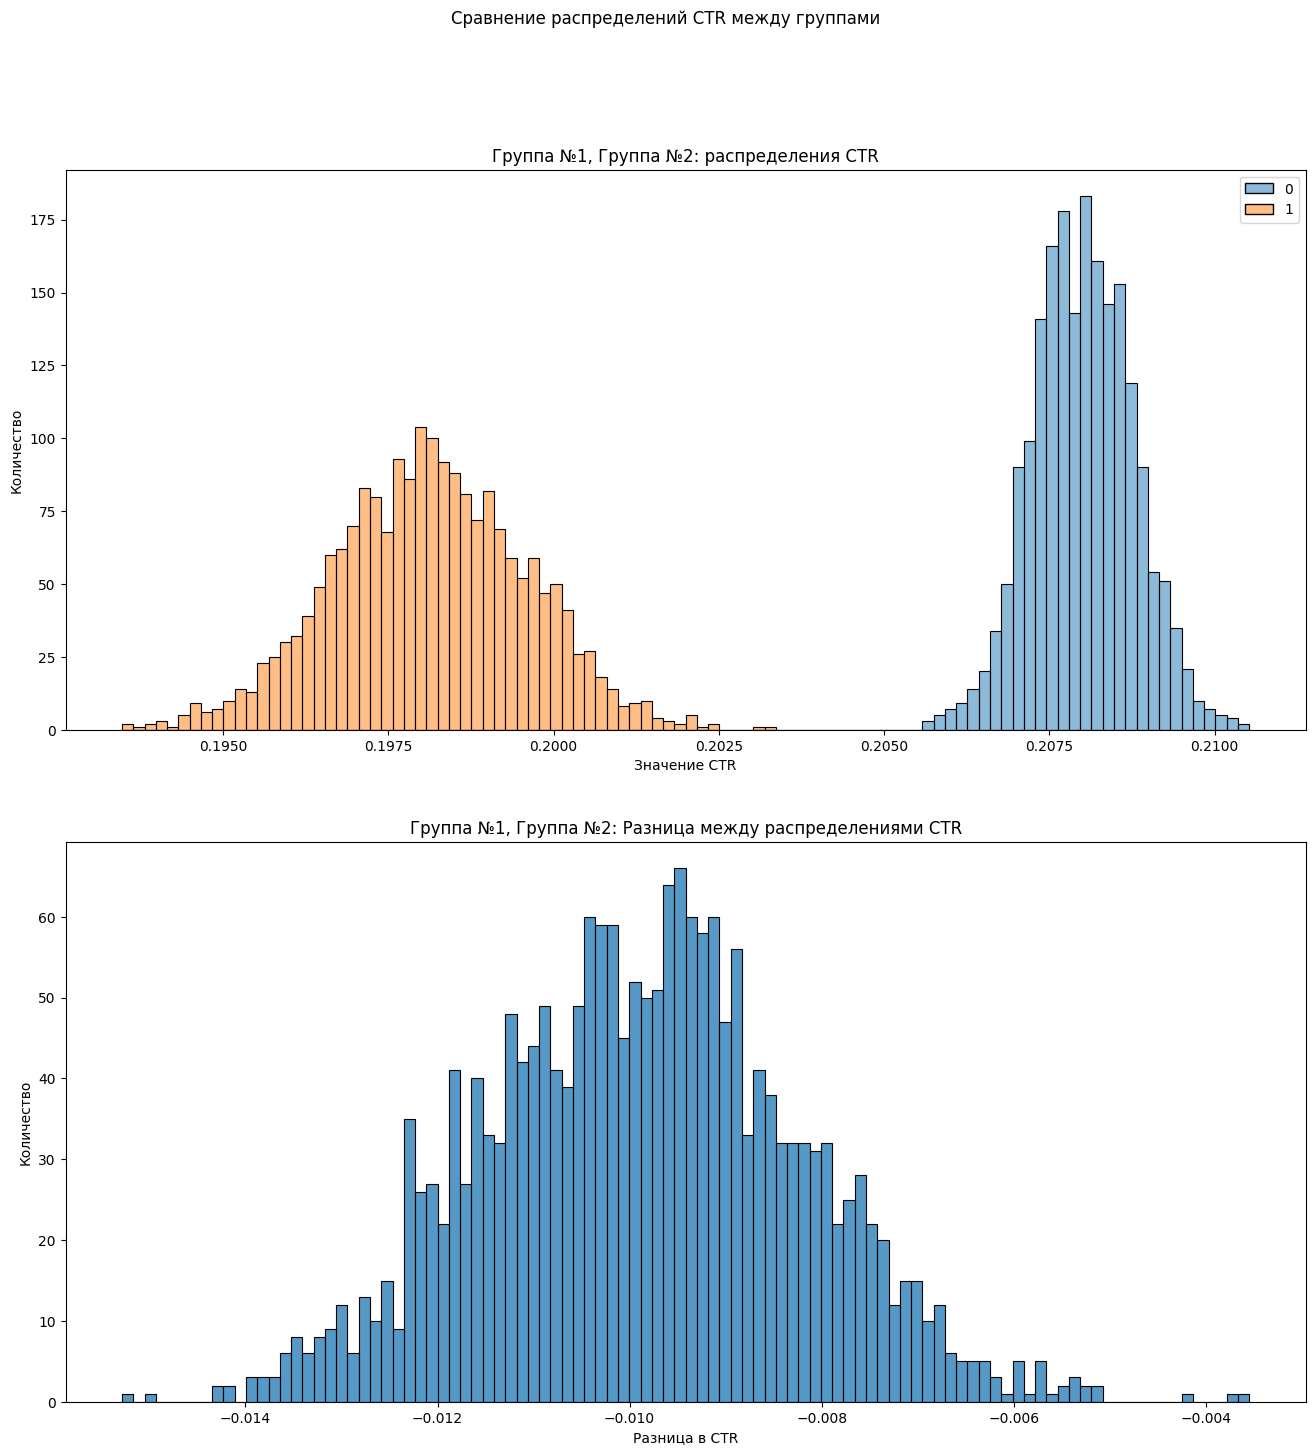

In [6]:
def bootstrap(likes1, views1, likes2, views2, n=2000):

    # Рассчитать Пуассоновские бутстрепы
    # Бутстрепы представлены матрицами с n строками и len(likes) столбцами
    # Каждая строка представляет собой Пуассоновское распределение длинной len(likes)
    pb1 = sp.stats.poisson(1).rvs((n, len(likes1))).astype(np.int64)
    pb2 = sp.stats.poisson(1).rvs((n, len(likes2))).astype(np.int64)

    # Рассчитать суммарное (по всем бутстрепам) распределение CTR
    globalCTR1 = (pb1 * likes1).sum(axis=1) / (pb1 * views1).sum(axis=1)
    globalCTR2 = (pb2 * likes2).sum(axis=1) / (pb2 * views2).sum(axis=1)

    return globalCTR1, globalCTR2


likes1 = group1_df.likes.to_numpy()
views1 = group1_df.views.to_numpy()
likes2 = group2_df.likes.to_numpy()
views2 = group2_df.views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

fig, axes = plt.subplots(2, 1, figsize=(16, 16))
fig.suptitle('Сравнение распределений CTR между группами')

axes[0].set_title('Группа №1, Группа №2: распределения CTR')
axes[0].set_xlabel('Значение CTR')
axes[0].set_ylabel('Количество')
sns.histplot(ax = axes[0], data = [ctr1, ctr2], bins = 100, kde = False)

axes[1].set_title('Группа №1, Группа №2: Разница между распределениями CTR')
axes[1].set_xlabel('Разница в CTR')
axes[1].set_ylabel('Количество')
sns.histplot(ax = axes[1], data = ctr2 - ctr1, bins = 100, kde = False)


In [7]:
ctr1_shapiro = sp.stats.shapiro(ctr1)
ctr1_dagostino = sp.stats.normaltest(ctr1)
ctr2_shapiro = sp.stats.shapiro(ctr2)
ctr2_dagostino = sp.stats.normaltest(ctr2)

print("Группа №1, распределение CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", ctr1_shapiro[1])
print("Критерий Д'Агостино:   ", ctr1_dagostino[1])

print("\nГруппа №2, распределение CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", ctr2_shapiro[1])
print("Критерий Д'Агостино:   ", ctr2_dagostino[1])

# Т-критерий Стьюдента для независимых выборок
# Гипотеза: среднее значение распределения Группы №1
# стохастически БОЛЬШЕ среднего значения распределения Группы №2
# То есть у Группы №1 (контрольной) в среднем CTR выше чем у Группы №2
ctr_ttest = sp.stats.ttest_ind(
    ctr1,
    ctr2,
    equal_var=False,
    alternative='greater'
)

# U-критерий Манна-Уитни
# Гипотеза: распределение Группы №1 стохастически БОЛЬШЕ распределения Группы №2
# То есть у Группы №1 (контрольной) CTR выше чем у Группы №2
ctr_mwutest = sp.stats.mannwhitneyu(
    ctr1,
    ctr2,
    alternative = 'greater'
)

print("\nГруппы №1 №2, сравнение CTR:")
print('Т-критерий Стьюдента:   ', ctr_ttest[1])
print('U-критерий Манна-Уитни: ', ctr_mwutest[1])

Группа №1, распределение CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.40485653281211853
Критерий Д'Агостино:    0.7434534585716073

Группа №2, распределение CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.8880505561828613
Критерий Д'Агостино:    0.9525895207697559

Группы №1 №2, сравнение CTR:
Т-критерий Стьюдента:    0.0
U-критерий Манна-Уитни:  0.0


### Выводы
С помощью графика распределений CTR мы можем убедиться что Группа №1 демонстрирует более высокий CTR чем Группа №2, так как их распределения CTR даже не пересекаются.
Это также заметно на графике разницы распределений CTR, где все дельты имеют строго отрицательное значение.
Распределения CTR также проходят проверку на нормальность, и используя односторонние Т-критерий Стьюдента и U-критерий Манна-Уитни мы еще раз продемонстрировали превосходство CTR Группы №1 над CTR Группы №2.


## Бакетное преобразование

<AxesSubplot:title={'center':'Группа №1, Группа №2: распределения 90-перцентиля CTR'}, xlabel='Значение 90-перцентиля CTR', ylabel='Количество'>

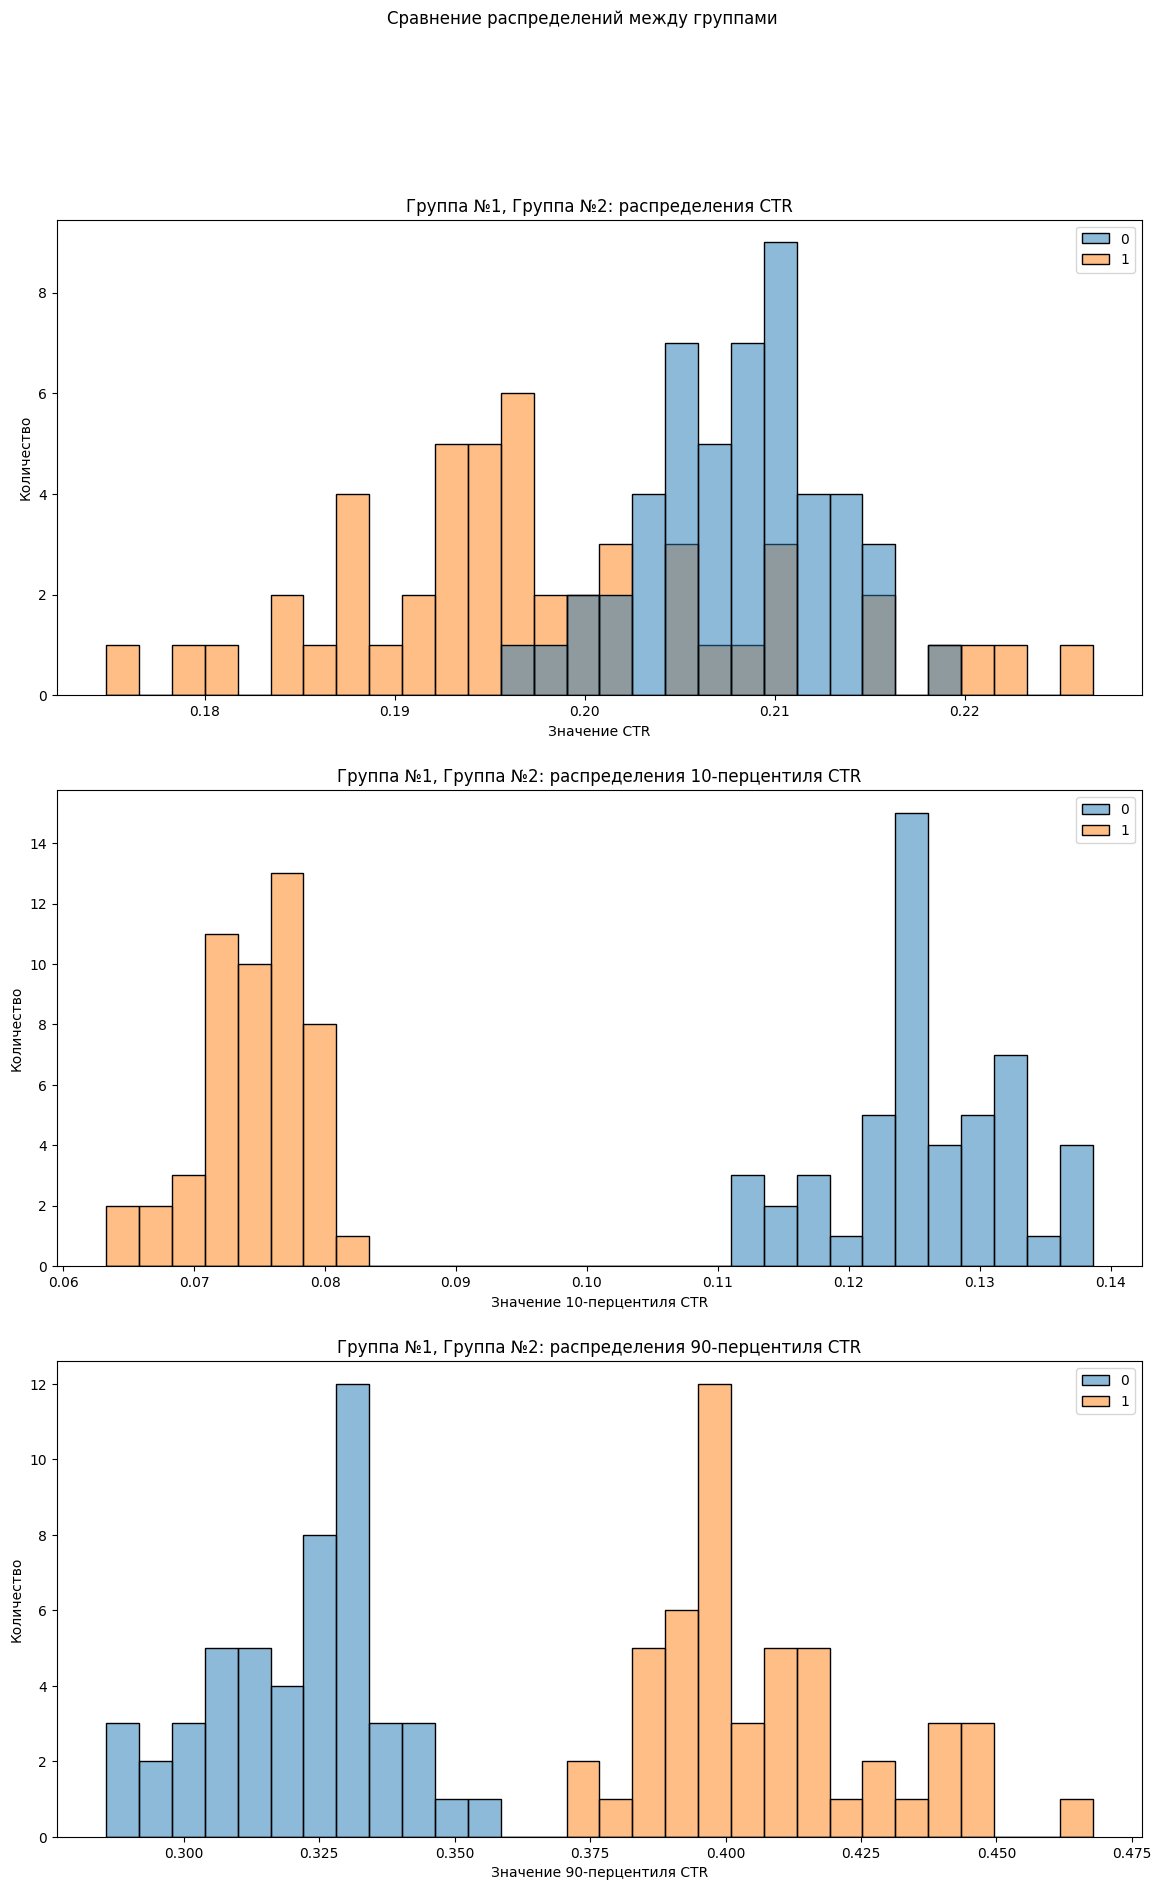

In [8]:
query = """
SELECT
    exp_group,
    bucket,
    sum(likes) / sum(views) as bucket_ctr,
    quantileExact(0.1)(ctr) as ctr1,
    quantileExact(0.9)(ctr) as ctr9

FROM (
    SELECT
        exp_group,
        xxHash64(user_id) % 50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) between '2022-12-02' and '2022-12-08'
        and exp_group in (1, 2)
    GROUP BY exp_group, bucket, user_id
)

GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(query, connection=connection)

ctr_b1 = df[df.exp_group == 1].bucket_ctr.values
ctr_b2 = df[df.exp_group == 2].bucket_ctr.values
ctr_q11 = df[df.exp_group == 1].ctr1.values
ctr_q12 = df[df.exp_group == 2].ctr1.values
ctr_q91 = df[df.exp_group == 1].ctr9.values
ctr_q92 = df[df.exp_group == 2].ctr9.values

fig, axes = plt.subplots(3, 1, figsize=(14, 21))
fig.suptitle('Сравнение распределений между группами')

axes[0].set_title('Группа №1, Группа №2: распределения CTR')
axes[0].set_xlabel('Значение CTR')
axes[0].set_ylabel('Количество')
sns.histplot(ax = axes[0], data = [ctr_b1, ctr_b2], bins = 30, kde = False)

axes[1].set_title('Группа №1, Группа №2: распределения 10-перцентиля CTR')
axes[1].set_xlabel('Значение 10-перцентиля CTR')
axes[1].set_ylabel('Количество')
sns.histplot(ax = axes[1], data = [ctr_q11, ctr_q12], bins = 30, kde = False)

axes[2].set_title('Группа №1, Группа №2: распределения 90-перцентиля CTR')
axes[2].set_xlabel('Значение 90-перцентиля CTR')
axes[2].set_ylabel('Количество')
sns.histplot(ax = axes[2], data = [ctr_q91, ctr_q92], bins = 30, kde = False)


In [9]:
ctr_b1_shapiro = sp.stats.shapiro(ctr1)
ctr_b1_dagostino = sp.stats.normaltest(ctr1)
ctr_b2_shapiro = sp.stats.shapiro(ctr2)
ctr_b2_dagostino = sp.stats.normaltest(ctr2)

ctr_q11_shapiro = sp.stats.shapiro(ctr1)
ctr_q11_dagostino = sp.stats.normaltest(ctr1)
ctr_q12_shapiro = sp.stats.shapiro(ctr2)
ctr_q12_dagostino = sp.stats.normaltest(ctr2)

ctr_q91_shapiro = sp.stats.shapiro(ctr1)
ctr_q91_dagostino = sp.stats.normaltest(ctr1)
ctr_q92_shapiro = sp.stats.shapiro(ctr2)
ctr_q92_dagostino = sp.stats.normaltest(ctr2)

print("Группа №1, распределение CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", ctr_b1_shapiro[1])
print("Критерий Д'Агостино:   ", ctr_b1_dagostino[1])

print("\nГруппа №2, распределение CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", ctr_b2_shapiro[1])
print("Критерий Д'Агостино:   ", ctr_b2_dagostino[1])

print("\nГруппа №1, распределение 10-перцентиля CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", ctr_q11_shapiro[1])
print("Критерий Д'Агостино:   ", ctr_q11_dagostino[1])

print("\nГруппа №2, распределение 10-перцентиля CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", ctr_q12_shapiro[1])
print("Критерий Д'Агостино:   ", ctr_q12_dagostino[1])

print("\nГруппа №1, распределение 90-перцентиля CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", ctr_q91_shapiro[1])
print("Критерий Д'Агостино:   ", ctr_q91_dagostino[1])

print("\nГруппа №2, распределение 90-перцентиля CTR, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", ctr_q92_shapiro[1])
print("Критерий Д'Агостино:   ", ctr_q92_dagostino[1])

# Т-критерий Стьюдента для независимых выборок
# Гипотеза: среднее значение распределения Группы №1
# стохастически БОЛЬШЕ среднего значения распределения Группы №2
# То есть у Группы №1 (контрольной) в среднем CTR выше чем у Группы №2
ctr_b_ttest = sp.stats.ttest_ind(ctr_b1, ctr_b2, equal_var=False, alternative='greater')
ctr_q1_ttest = sp.stats.ttest_ind(ctr_q11, ctr_q12, equal_var=False, alternative='greater')
ctr_q9_ttest = sp.stats.ttest_ind(ctr_q91, ctr_q92, equal_var=False, alternative='greater')

# U-критерий Манна-Уитни
# Гипотеза: распределение Группы №1 стохастически БОЛЬШЕ распределения Группы №2
# То есть у Группы №1 (контрольной) CTR выше чем у Группы №2
ctr_b_mwutest = sp.stats.mannwhitneyu(ctr_b1, ctr_b2, alternative = 'greater')
ctr_q1_mwutest = sp.stats.mannwhitneyu(ctr_q11, ctr_q12, alternative = 'greater')
ctr_q9_mwutest = sp.stats.mannwhitneyu(ctr_q91, ctr_q92, alternative = 'greater')

print("\nГруппы №1 №2, сравнение CTR:")
print('Т-критерий Стьюдента:   ', ctr_b_ttest[1])
print('U-критерий Манна-Уитни: ', ctr_b_mwutest[1])

print("\nГруппы №1 №2, сравнение 10-перцентилей CTR:")
print('Т-критерий Стьюдента:   ', ctr_q1_ttest[1])
print('U-критерий Манна-Уитни: ', ctr_q1_mwutest[1])

print("\nГруппы №1 №2, сравнение 90-перцентилей CTR:")
print('Т-критерий Стьюдента:   ', ctr_q9_ttest[1])
print('U-критерий Манна-Уитни: ', ctr_q9_mwutest[1])

Группа №1, распределение CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.40485653281211853
Критерий Д'Агостино:    0.7434534585716073

Группа №2, распределение CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.8880505561828613
Критерий Д'Агостино:    0.9525895207697559

Группа №1, распределение 10-перцентиля CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.40485653281211853
Критерий Д'Агостино:    0.7434534585716073

Группа №2, распределение 10-перцентиля CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.8880505561828613
Критерий Д'Агостино:    0.9525895207697559

Группа №1, распределение 90-перцентиля CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.40485653281211853
Критерий Д'Агостино:    0.7434534585716073

Группа №2, распределение 90-перцентиля CTR, проверка на нормальность:
Критерий Шапиро-Уилка:  0.8880505561828613
Критерий Д'Агостино:    0.9525895207697559

Группы №1 №2, сравнение CTR:
Т-критерий Стьюдента:    1.7227975824972953e-07
U-крит

### Выводы
Проведя визуальный анализ, мы удостоверились, что полученные бакетные распределения являются одномодальными и напонимают нормальные распределения.
Визуально сравнивая бакетные распределения мы также можем убедиться что в целом Группа №1 демонстрирует более высокий CTR нежели Группа №2.
Такую же картину мы можем наблюдать при исследовании распределений 10-перцентилей Группы №1 и Группы №2.
Тем не менее, при сравнении распределений 90-перцентилей, мы можем увидеть полностью противоположную картину, где Группа №2 демонстрирует более высокий CTR чем Группа №1.
Это связано с тем что распеределние CTR Группы №2 изначально является двухмодальным, и не смотря на принятие одномодальной формы после процедуры бакетизации, сохраняет очень "длинный правый хвост".
Что еще раз подчеркивает важность выбора правильной метрики при обобщении бакетизации.

Наши выводы нуждаются в аналитическом подтверждении.
Мы проверили и подтвердили нормальность всех исследуемых распределений с помощью критерия Шапиро-Уилка и критерия Д'Агостино.
Также, с помощью односторонних Т-критерия Стьюдента и U-критерия Манна-Уитни, мы подтвердили наши предположения о превосходстве CTR Группы №1 над CTR Группы №2, и о некорректности использования 90-перцентиля в качестве обобщающей метрики при бакетизации в нашем случае.


# Общие выводы
## Проведенный анализ
Мы провели скурпулезный визуальный и аналитический анализы распределий CTR у экспериментальных групп пользователей №1 и №2.
Для проверки нормальности распределений мы использовали критерий Шапиро-Уилка и критерий Д'Агостино.
Для сравнения распределений между собой мы использовали Т-критерий Стьюдента и U-критерий Манна-Уитни.
Для трансформации исходных данных мы использовали сглаживание Лапласа, Пуассоновский бутстреп, и бакетное преобразование.

## Результаты анализа
На основе проведенного анализа мы можем утверждать что CTR Группы №1 превосходит CTR Группы №2 в подавляющем числе комбинаций трансформации данных и статистических критериев.
Следовательно, <b>мы не можем рекомендовать изучаемый алгоритм для внедрения</b>.

## Потенциальные причины поведения Группы №2
Двумодальность распределения CTR Группы №2 указывает на то, что возникло 2 подгруппы пользователей с разным поведением.
Причем первая подгруппа (состоящая из большего кол-ва пользователей) продемонстрировала уменьшение CTR, в то время как вторая подгруппа (состоящая из меньшего кол-ва пользователей) продемонстрировала увеличение CTR.
Такое поведение в ответ на введение нового алгоритма рекомендаций может быть связано с тем что алгоритм был "перетренирован" (overfitted) под определенную группу пользователей, что может быть следствием неправильного отбора данных для тренировки рекомендательного алгоритма.
Это объяснит тот факт что меньшая подгруппа (под которую алгоритм был "перетренирован") показала повышение CTR, в то время как большинство пользователей показала ухудшение CTR.